In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Redirect to directory that ALL is in
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [4]:
data_dir = 'ALL'

In [ ]:
# Update the class_to_label dictionary based on the actual directories found.
# The previous output showed 'all_pro', 'all_pre', 'all_benign', 'all_early'
class_to_label = {'all_benign': 0, 'all_early': 1, 'all_pre': 2, 'all_pro': 3}


class ALLDatasetSplit(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

all_image_files = []
all_labels = []

# Iterate through each folder in ALL
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        if class_name in class_to_label: # Only process directories that are in the class_to_label map
            # Assign image_file to all_image_files and class labels all_labels
            for image_file in os.listdir(class_dir):
                all_image_files.append(os.path.join(class_dir, image_file))
                all_labels.append(class_to_label[class_name])
        else:
            print(f"Warning: Directory '{class_name}' not found in class_to_label and will be skipped.")



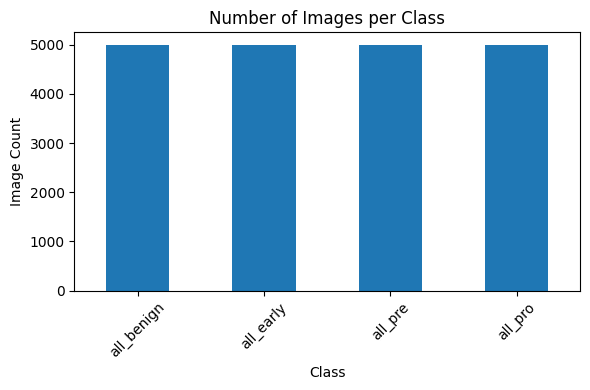

In [ ]:
class_counts = {}

for class_name in class_to_label:
    class_dir = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    class_counts[class_name] = len(images)

pd.DataFrame.from_dict(class_counts, orient='index', columns=["Count"])

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=["Count"])

# Plot
plt.figure(figsize=(6,4))
df["Count"].plot(kind='bar')

plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

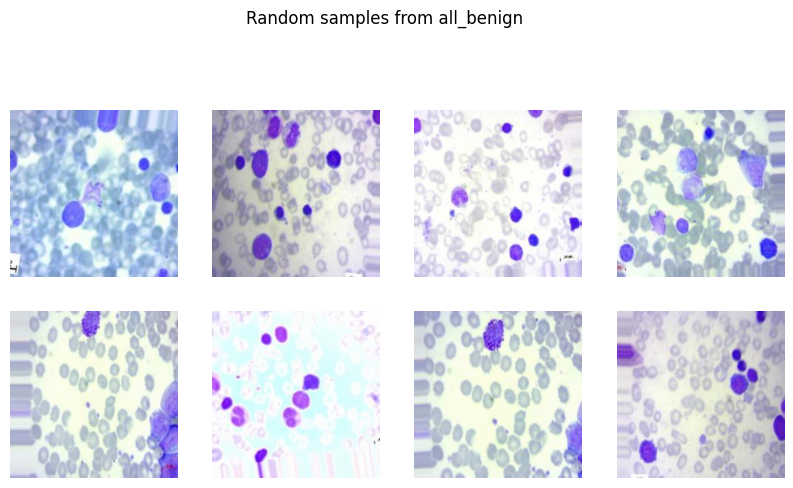

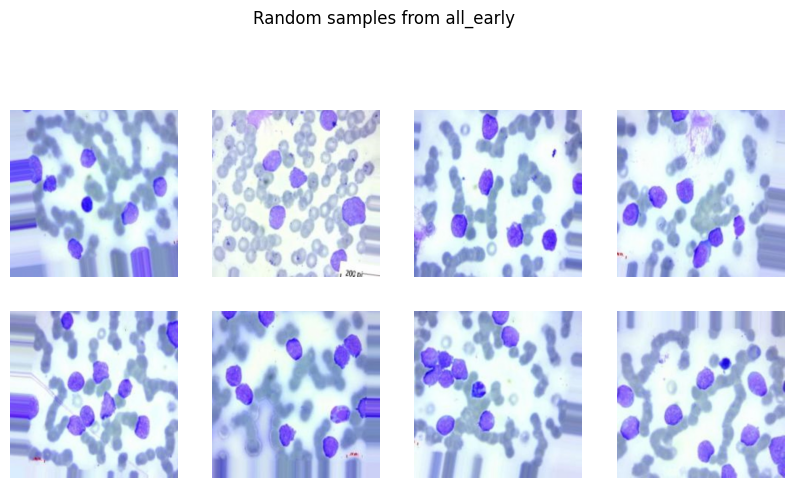

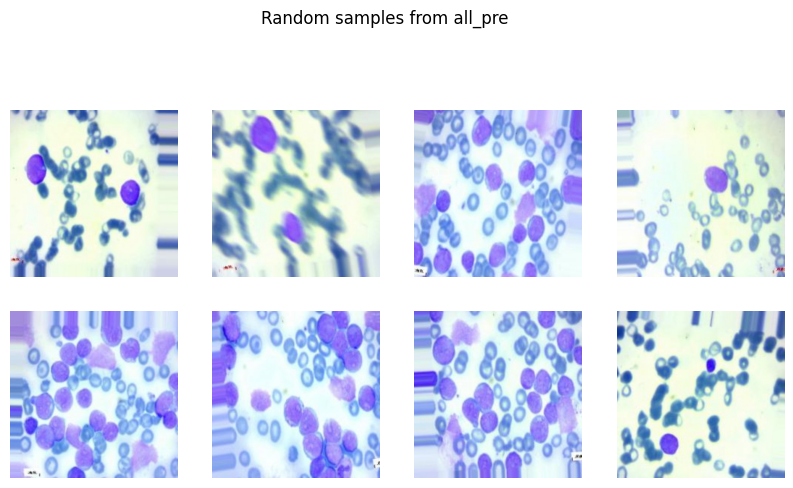

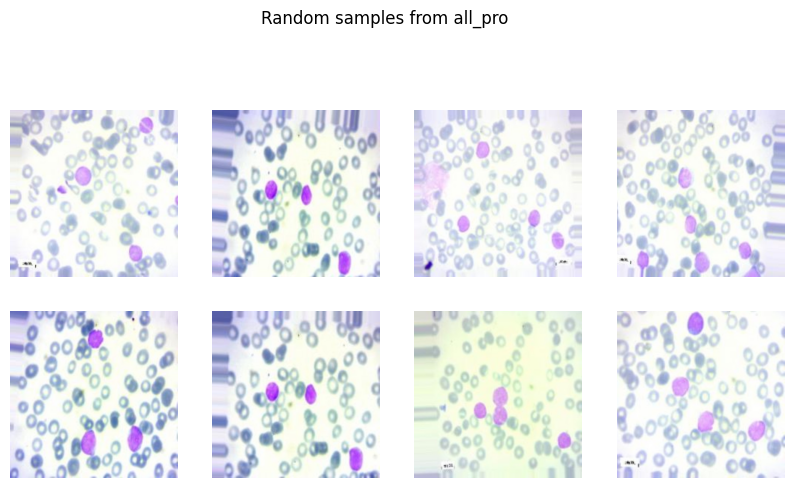

In [ ]:
import random

def show_samples(class_name, n=8):
    folder = os.path.join(data_dir, class_name)
    files = [os.path.join(folder,f) for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    sample = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(10,10))
    for i, f in enumerate(sample):
        img = Image.open(f)
        plt.subplot(4,4,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Random samples from {class_name}")
    plt.show()

for c in class_to_label.keys():
    show_samples(c)


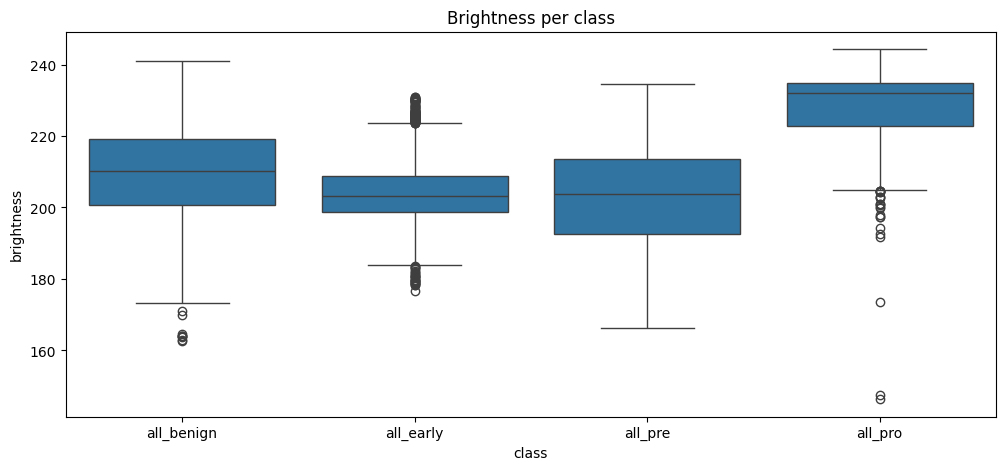

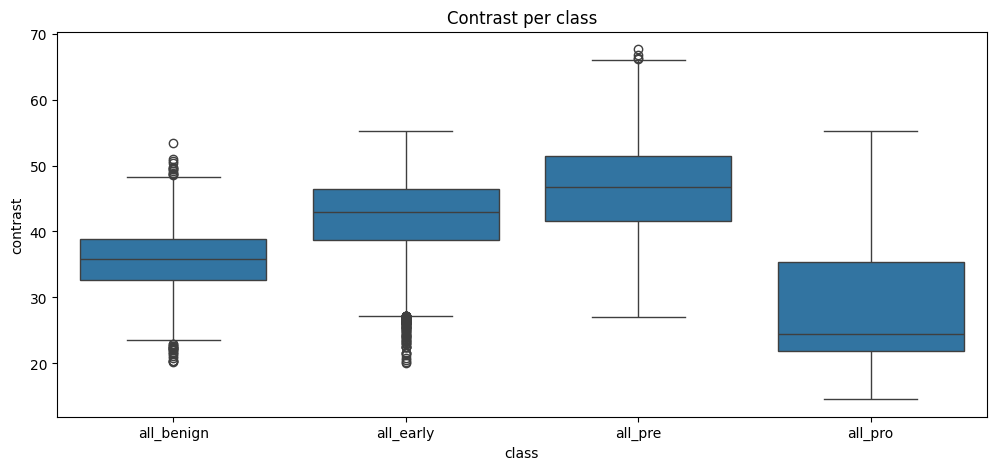

In [ ]:
import numpy as np

brightness = []
contrast = []
labels = []

for c in class_to_label:
    folder = os.path.join(data_dir, c)
    for f in os.listdir(folder):
        if not f.lower().endswith('.jpg'):
            continue

        img = Image.open(os.path.join(folder, f)).convert("L")
        arr = np.array(img)

        brightness.append(arr.mean())
        contrast.append(arr.std())
        labels.append(c)

import seaborn as sns
import pandas as pd

df = pd.DataFrame({"class": labels, "brightness": brightness, "contrast": contrast})

plt.figure(figsize=(12,5))
sns.boxplot(data=df, x="class", y="brightness")
plt.title("Brightness per class")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=df, x="class", y="contrast")
plt.title("Contrast per class")
plt.show()


In [ ]:
def show_edge_maps(class_name, n=6):
    folder = os.path.join(data_dir, class_name)
    files = [os.path.join(folder, f) for f in os.listdir(folder)
             if f.lower().endswith(('.jpg','.jpeg','.png'))]

    sample = random.sample(files, min(n, len(files)))

    plt.figure(figsize=(12, 6*n))

    for i, fpath in enumerate(sample):
        img = cv2.imread(fpath)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Sobel edges
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)

        # Canny edges
        canny = cv2.Canny(gray, 80, 160)

        # Plot
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Original ({class_name})")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(sobel, cmap='gray')
        plt.title("Sobel (Texture)")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(canny, cmap='gray')
        plt.title("Canny (Boundaries)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


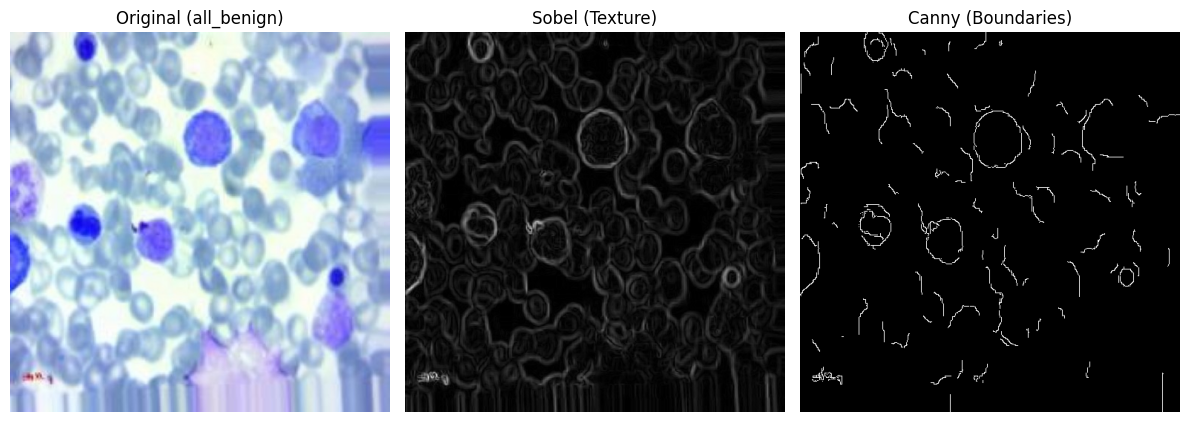

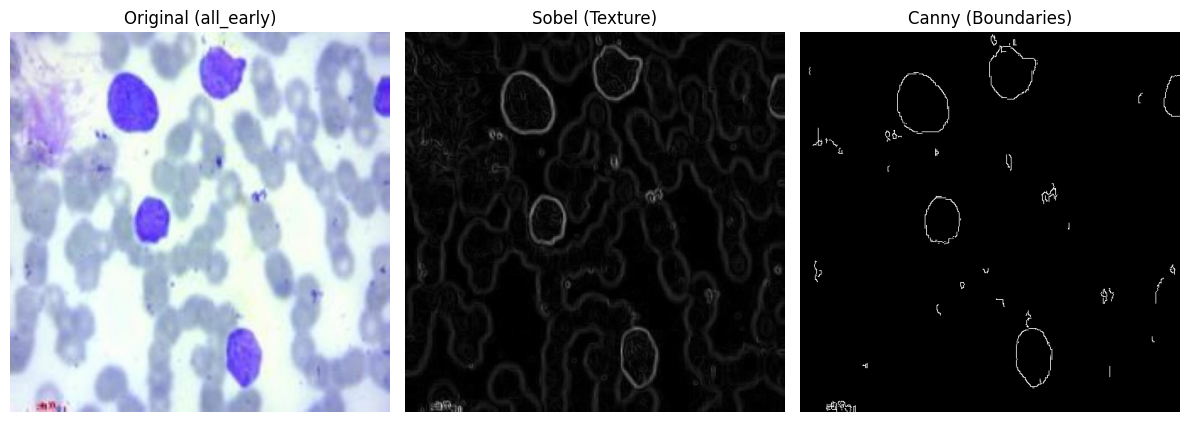

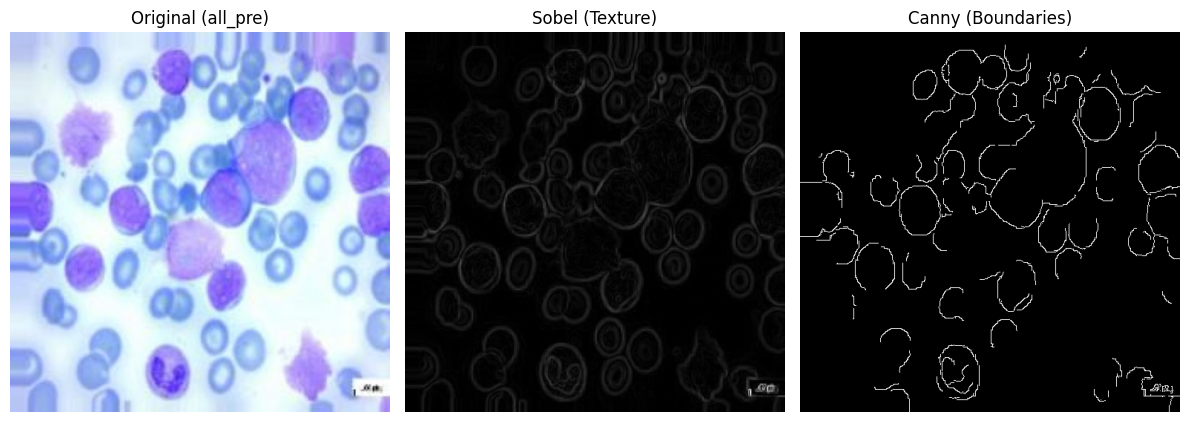

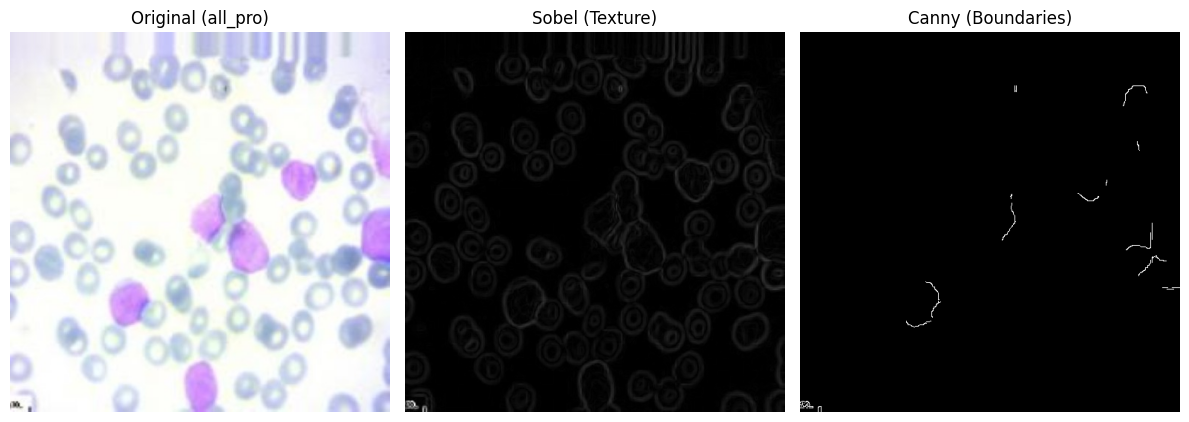

In [ ]:
for c in class_to_label.keys():
    show_edge_maps(c, n=1)


# Data Split

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 123

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Get class names from the full dataset before splitting
class_names = full_ds.class_names
num_classes = len(class_names)
print("\nClasses:", class_names)


dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size  # ensures exact total

train_ds = full_ds.take(train_size)
temp_ds  = full_ds.skip(train_size)

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

train_ds = train_ds.shuffle(5000)

print("\nTrain batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

for i, class_name in enumerate(class_names):
  print(f"Label {i}: {class_name}")

Found 20001 files belonging to 4 classes.

Classes: ['all_benign', 'all_early', 'all_pre', 'all_pro']

Train batches: 438
Val batches: 93
Test batches: 95
Label 0: all_benign
Label 1: all_early
Label 2: all_pre
Label 3: all_pro


In [6]:
for name, ds in [("train", train_ds), ("val", val_ds), ("test", test_ds)]:
    labels = []
    for _, y in ds:
        labels.extend(y.numpy())
    print(name, np.bincount(labels))

train [3497 3514 3523 3482]
val [768 741 737 730]
test [736 750 739 784]


# UMAP

In [7]:
!pip install umap-learn

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow as tf

# Load pretrained ResNet50 without top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
train_unbatched = train_ds.unbatch()

class_to_images = {i: [] for i in range(num_classes)}

for img, label in train_unbatched:
    class_to_images[int(label.numpy())].append(img)

N = 500  # per class
balanced_images = []
balanced_labels = []

for cls in range(num_classes):
    imgs = class_to_images[cls]
    idx = np.random.choice(len(imgs), N, replace=False)
    for i in idx:
        balanced_images.append(imgs[i])
        balanced_labels.append(cls)

In [11]:
balanced_ds = tf.data.Dataset.from_tensor_slices(
    (tf.stack(balanced_images), tf.constant(balanced_labels))
).batch(128)


In [12]:
train_embeddings = []
train_labels = []

for batch_imgs, batch_labels in balanced_ds:
    batch_imgs = tf.keras.applications.resnet50.preprocess_input(batch_imgs * 255.0)
    feats = base_model(batch_imgs, training=False).numpy()
    train_embeddings.append(feats)
    train_labels.append(batch_labels.numpy())

train_embeddings = np.vstack(train_embeddings)
train_labels = np.concatenate(train_labels)
label_names = [class_names[int(i)] for i in train_labels]

In [16]:
import umap
X_scaled = StandardScaler().fit_transform(train_embeddings)
embedding = umap.UMAP(n_neighbors=15, min_dist=0.05).fit_transform(X_scaled)


<Axes: xlabel='x', ylabel='y'>

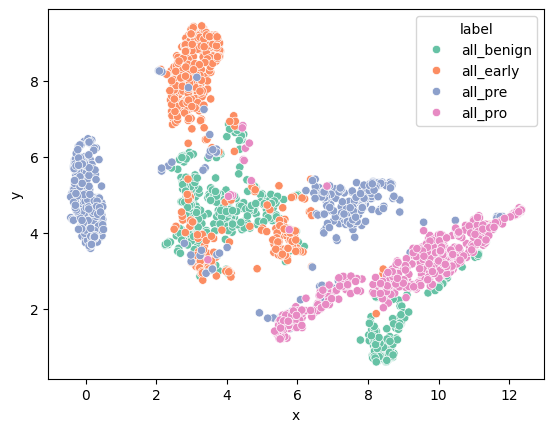

In [17]:
df = pd.DataFrame({"x": embedding[:,0], "y": embedding[:,1], "label": label_names})
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="Set2")